# Notebook - Análise da evasão

Dados do Instituto de Ciências Exatas (IE).

### Importando bibliotecas:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv

import utils
import process
import pre_process

%matplotlib inline

In [ ]:
# Reload module

# import importlib
# importlib.reload(pre_process)

 ### Leitura dos dados

In [2]:
DATA_FILE = '../data/ie_data.csv'
# DATA_FILE = '../data/test_data.csv'
data_pre = pd.read_csv(DATA_FILE, sep=';', low_memory=False)

## Pré-Processamento

In [3]:
attrs = []
attrs_cat = []
data_pre = pre_process.format_data(data_pre)
data_pre = pre_process.erase_attr(data_pre)

year_range = [1990, 2014]
data_pre = pre_process.time_frame(data_pre, year_range)

horizon = 1  # 1 year = 2 semesters
data_pre = pre_process.beyond_horizon(data_pre, horizon)

data_pre = pre_process.public_school(data_pre, attrs)
data_pre = pre_process.dropout(data_pre, attrs)
data_pre = pre_process.course(data_pre, attrs)
data_pre = pre_process.gender(data_pre, attrs)
data_pre = pre_process.entry(data_pre, attrs, attrs_cat)
data_pre = pre_process.age(data_pre, attrs)

data_pre = pre_process.cic_courses(data_pre)
data_pre = pre_process.erase_internal_transfer_students(data_pre)

credits_dict = pre_process.subject_credits(data_pre)

data_pre = pre_process.quota(data_pre, attrs, attrs_cat)
data_pre = pre_process.one_hot_encoding(data_pre, ['quota_type', 'entry'], attrs, attrs_cat)
data_pre = data_pre.dropna()

Divide dataframe by course:

In [4]:
data_course, attrs_course, attrs_cat_course = pre_process.divide_course(
    data_pre, attrs, attrs_cat
)

data_course['all'] = data_pre
attrs_course['all'] = attrs.copy()
attrs_cat_course['all'] = attrs_cat.copy()
attrs_cat_course['all'].append('course')

### Process Subjects and CEP

The Subjects are processed for each course individually, and Cep needs to be processed before all other attributes and drop_duplicates, otherwise it takes too long to process.

In [5]:
keys = data_course.keys()
for course in keys:
    print(course)
    data = data_course[course].copy()
    attrs = attrs_course[course]

    # Process subjects
    data = pre_process.add_semester_prefix(data)
    data = pre_process.subjects(data, attrs, horizon, credits_dict)

    # Process CEP
    # It needs to be processed before drop_duplicates, or it takes too long to process.
    data = data[attrs+['cep', 'aluno']].drop_duplicates()
    data = pre_process.cep(data, attrs)

    data_course[course] = data.copy()

ciência da computação
computação
engenharia de computação
engenharia mecatrônica
all


In [6]:
data_process = data_course.copy()

## Analysis

Tamanho da base:

In [7]:
for course in data_course.keys():
    print(f'{course} = {data_course[course].shape}')
    print(f'quota \n{data_course[course]["quota"].value_counts()}')
    print('\n')

ciência da computação = (1450, 51)
quota 
False    1341
True      109
Name: quota, dtype: int64


computação = (1070, 51)
quota 
False    969
True     101
Name: quota, dtype: int64


engenharia de computação = (380, 51)
quota 
False    313
True      67
Name: quota, dtype: int64


engenharia mecatrônica = (964, 51)
quota 
False    886
True      78
Name: quota, dtype: int64


all = (3864, 52)
quota 
False    3509
True      355
Name: quota, dtype: int64




Desbalanceamento da base:

In [8]:
for course in data_course.keys():
    print(f'{course}:')
    freq = data_course[course]['dropout'].value_counts()
    print(freq)
    print('\n')

ciência da computação:
True     742
False    708
Name: dropout, dtype: int64


computação:
True     752
False    318
Name: dropout, dtype: int64


engenharia de computação:
True     215
False    165
Name: dropout, dtype: int64


engenharia mecatrônica:
False    557
True     407
Name: dropout, dtype: int64


all:
True     2116
False    1748
Name: dropout, dtype: int64




## Testes

In [ ]:
len(data_course['all']['aluno'].drop_duplicates())

In [ ]:
data_course['all'].columns

In [ ]:
dict(data_course['all']['1_approved_credits'].value_counts())

In [ ]:
data_test = data_course['all']

## Processamento

In [9]:
def catboost(data, attrs, attrs_cat):
    output_attr = 'dropout'

    X = data[attrs].drop(columns=[output_attr])
    y = data[output_attr]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )   

    # dropout imbalance
    output_freq = data[output_attr].value_counts()
    scale = output_freq[0] / output_freq[1]  # negative / positive

    model = CatBoostClassifier(scale_pos_weight=scale, depth=5, one_hot_max_size=4)
    model.fit(
        X_train, y_train,
        cat_features=attrs_cat, plot=False, silent=True
    )

#     cv_dataset = Pool(
#         data=X,
#         label=y,
#         cat_features=attrs_cat
#     )

#     params = {
#         "iterations": 100,
#         "depth": 2,
#         "loss_function": "Logloss",
#         "verbose": False,
#         "depth": 5,
#         "scale_pos_weight": scale
#     }

#     scores = cv(
#         cv_dataset,
#         params,
#         fold_count=5, 
#         plot="True",
#         return_models="True"
#     )[4]
    
#     print(scores)

    
#     print(model.get_all_params())

    process.show_metrics(model, X_train, y_train, X_test, y_test)
    # utils.precision_recall_graph(model, X_test, y_test)

    # shap importance
    shap_values = model.get_feature_importance(
        Pool(X_test, label=y_test, cat_features=attrs_cat), 
        type="ShapValues"
    )
    shap_values = shap_values[:,:-1]
    shap.summary_plot(
        shap_values, X_test, 
        plot_type='bar', 
        plot_size=(15,15),
        max_display=30
    )

    return model, X_test

Process all dataframes:


Curso = ciência da computação
Treino:
    Accuracy = 90.74%
    Precision = 86.96%
    Recall = 96.34%
    FScore = 92.26%
Teste:
    Accuracy = 79.31%
    Precision = 75.88%
    Recall = 87.44%
    FScore = 82.30%


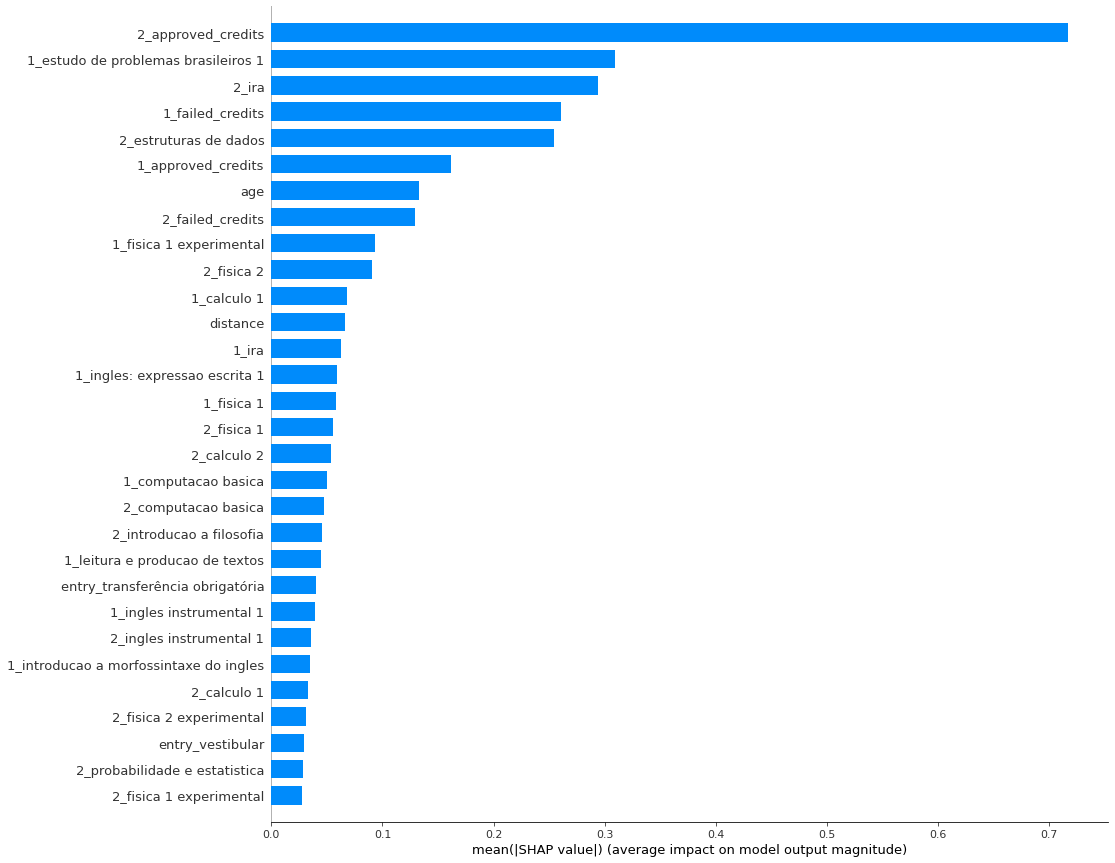


Curso = computação
Treino:
    Accuracy = 93.86%
    Precision = 94.44%
    Recall = 96.96%
    FScore = 95.91%
Teste:
    Accuracy = 73.21%
    Precision = 78.23%
    Recall = 85.84%
    FScore = 82.55%


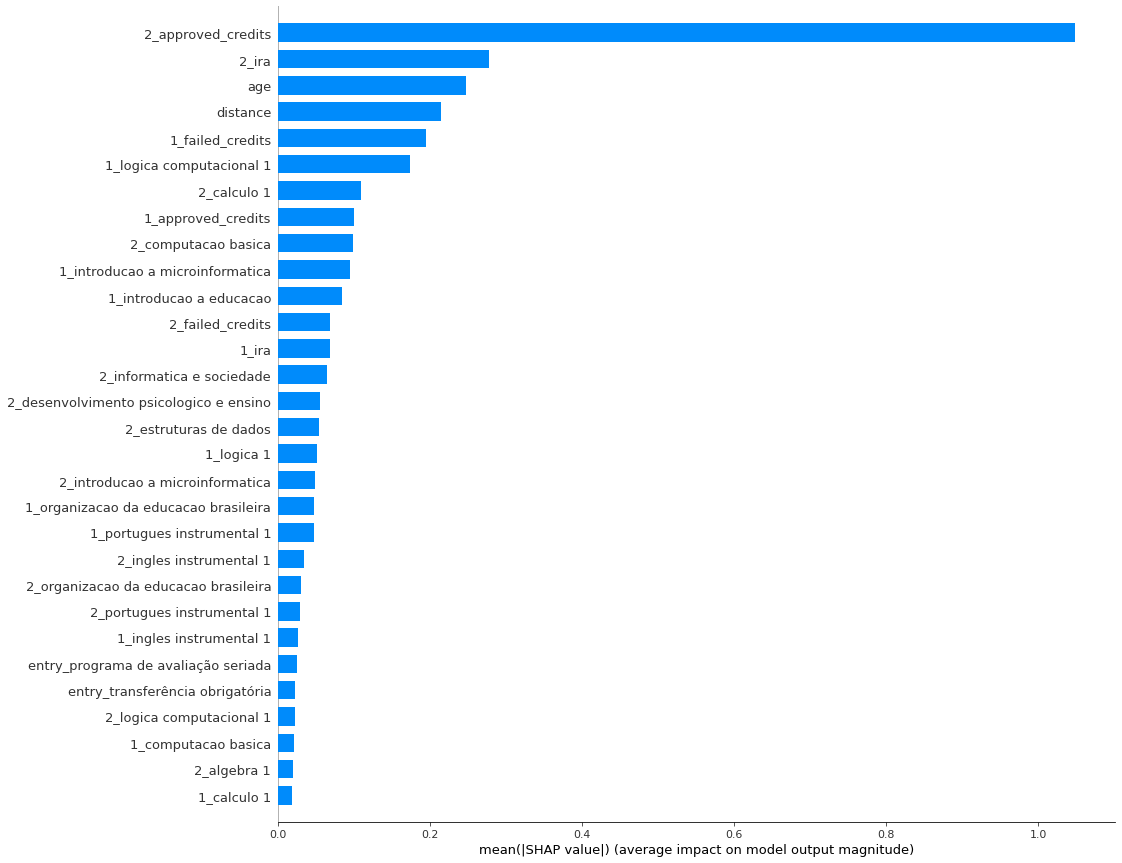


Curso = engenharia de computação
Treino:
    Accuracy = 93.61%
    Precision = 93.51%
    Recall = 95.36%
    FScore = 94.59%
Teste:
    Accuracy = 74.56%
    Precision = 72.73%
    Recall = 87.50%
    FScore = 80.78%


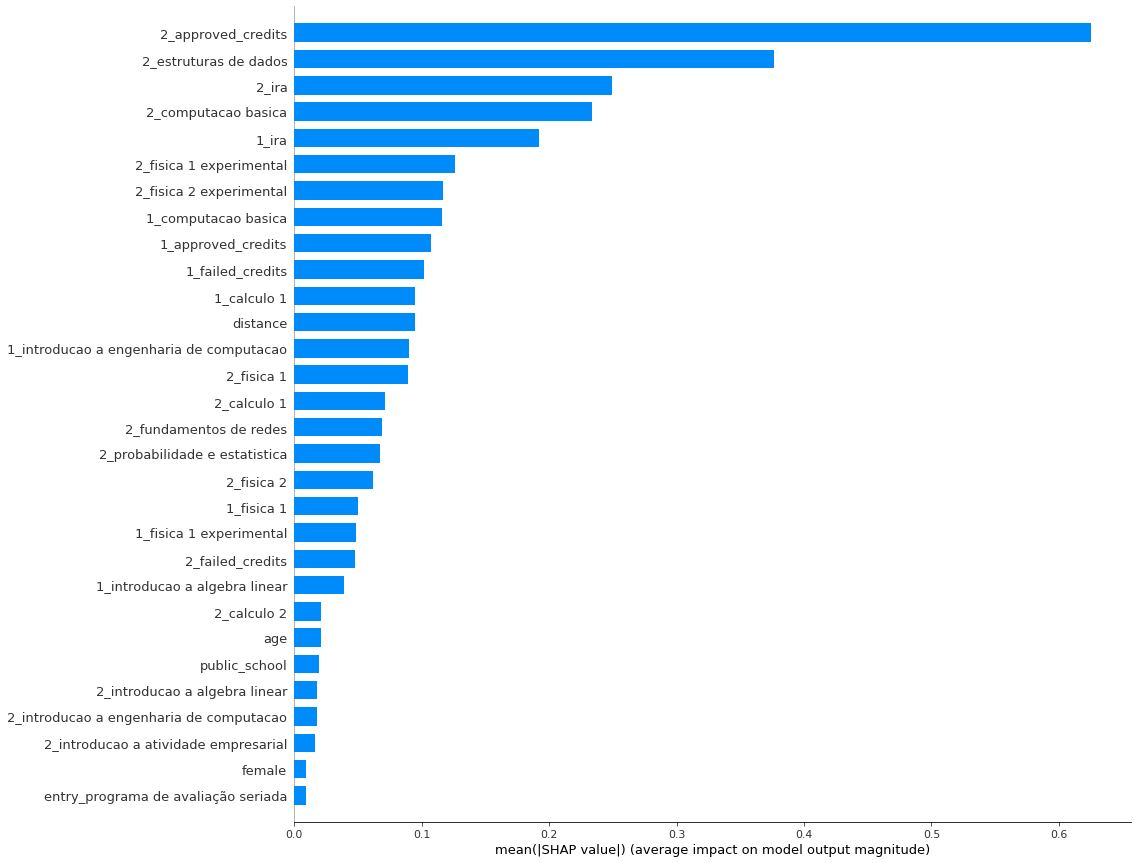


Curso = engenharia mecatrônica
Treino:
    Accuracy = 89.17%
    Precision = 81.93%
    Recall = 95.44%
    FScore = 89.40%
Teste:
    Accuracy = 81.03%
    Precision = 73.43%
    Recall = 86.07%
    FScore = 80.39%


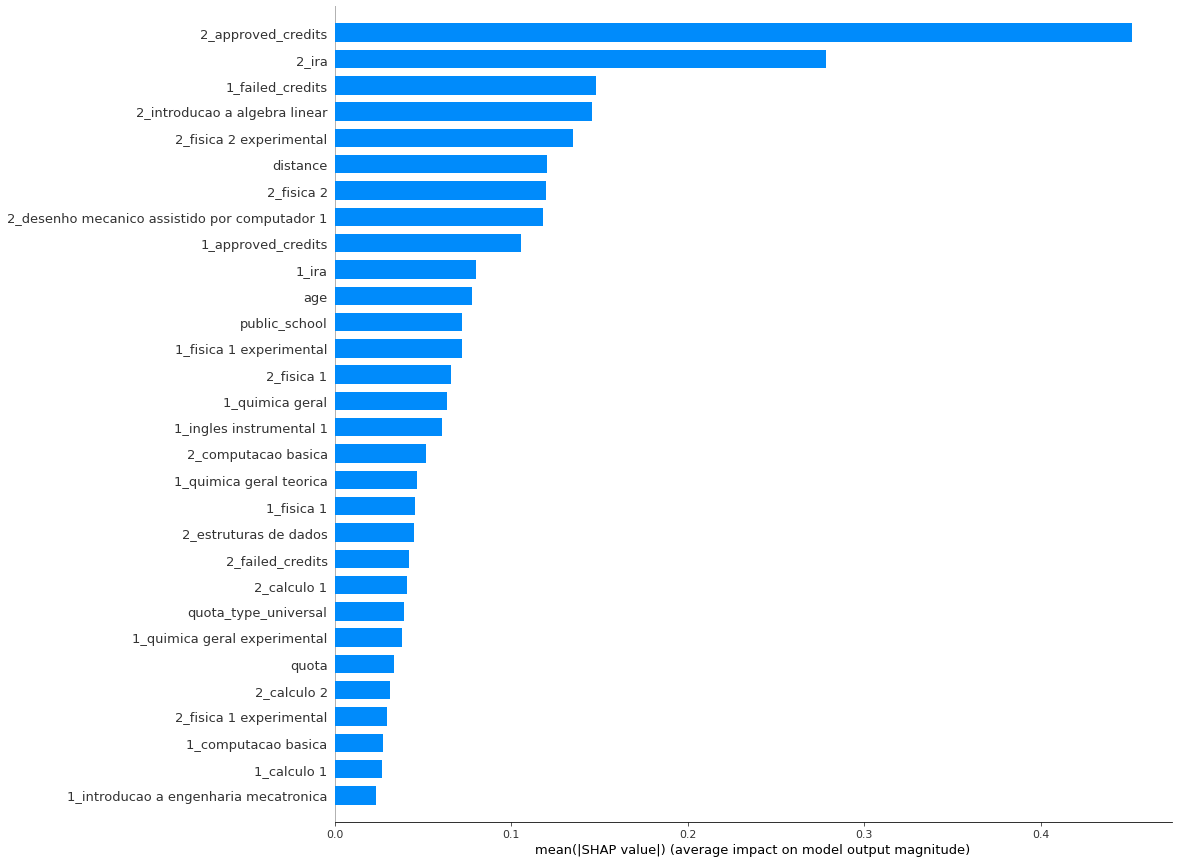


Curso = all
Treino:
    Accuracy = 86.61%
    Precision = 84.99%
    Recall = 91.76%
    FScore = 88.86%
Teste:
    Accuracy = 77.16%
    Precision = 75.69%
    Recall = 85.83%
    FScore = 81.36%


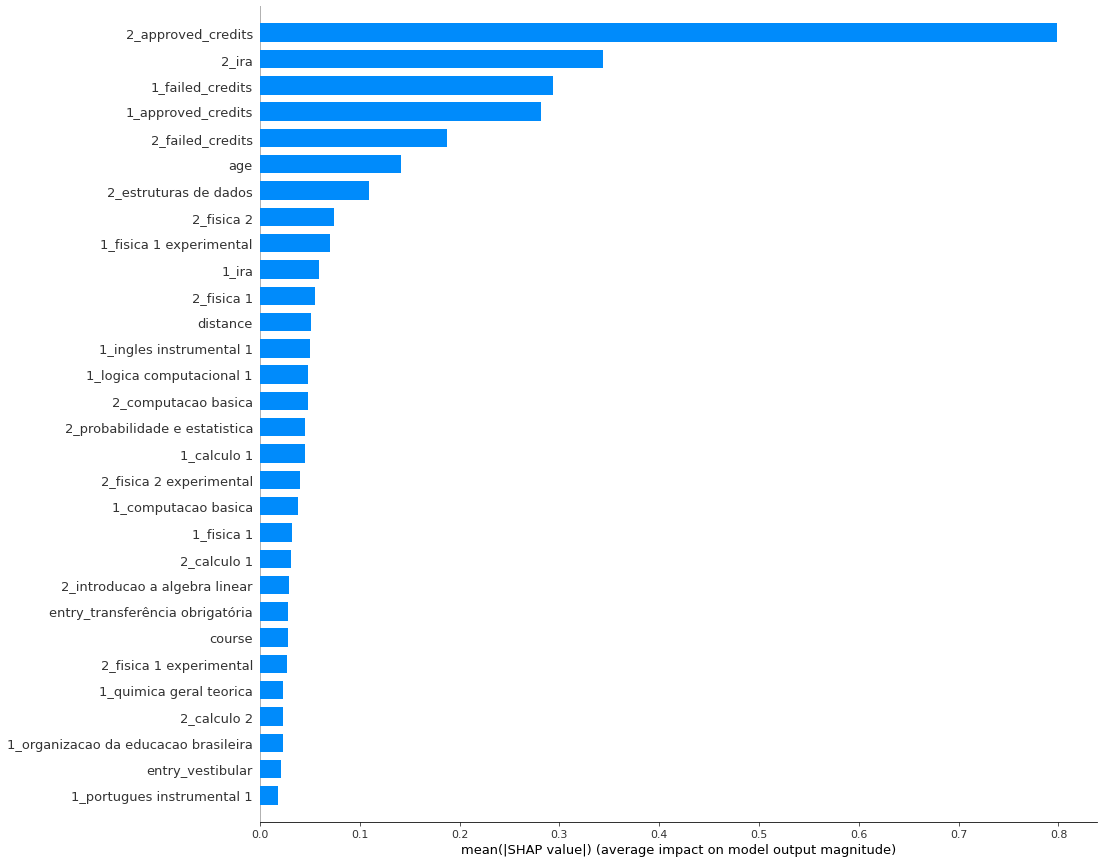

In [10]:
for course, data in data_process.items():
    print(f'\nCurso = {course}')
    model, X_test = catboost(
        data,
        attrs_course[course],
        attrs_cat_course[course]
    )

Process a single dataframe:

In [ ]:
course = 'engenharia mecatrônica'
model, X_test = catboost(
        data_process[course],
        attrs_course[course],
        attrs_cat_course[course]
    )

## Using SHAP

In [ ]:
explainer = shap.TreeExplainer(model)
start_index = 0
end_index = len(X_test)
shap_values = explainer.shap_values(X_test[start_index:end_index])

shap.initjs()

In [ ]:
id = 23
shap.force_plot(explainer.expected_value,
                shap_values[id:id+1],
                X_test[id:id+1])

In [ ]:
shap.force_plot(explainer.expected_value,
                shap_values,
                X_test[start_index:end_index])

In [ ]:
shap.summary_plot(shap_values, X_test[start_index:end_index], plot_size=(20,20), max_display=50)

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=50)

In [ ]:
shap.dependence_plot('1_ira', shap_values, X_test[start_index:end_index], interaction_index='distance')

## Plot Student's House Coordinates

In [11]:
attr = ['aluno', 'cep', 'dropout', 'course']
# keys = data_course.keys()
keys = ['computação']
for course in keys:
    data = data_course[course].copy()[attr].drop_duplicates()
    utils.plot_coordinates(data, course)
#     utils.plot_coordinates_density(data, course)

KeyError: "['course'] not in index"